In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.426122  0.422316  0.840206 -0.213278  1.372481  0.742271  1.533053   
  1  -0.479003  0.688237  0.519724 -0.189849  1.286141  0.617231 -0.563177   
  2  -0.064917 -0.211610  0.210369  0.340963  0.850014  0.824195  0.466893   
  3  -0.587824  0.541741  0.814204  0.290758  0.449888  0.808077 -0.064289   
  4  -0.385127  0.711069  1.242746  0.509017  1.330697  0.871195  0.439505   
  5  -0.356811  0.632423  0.586876  0.679617  0.211374  0.205078  0.604913   
  6   0.149464  1.012180  0.761921  0.388365 -1.031289 -0.690537  0.287532   
  7   0.931065 -0.584034  0.292540  0.702396  0.220311 -0.333552 -0.842847   
  8   0.468483  1.639184 -0.609865 -0.192379  0.204877 -0.030810  1.211828   
  9   0.024395  0.133579  0.263047 -0.826792 -0.344175  0.288398  0.280358   
  10  0.015709 -0.295242 -0.396565  0.136450  0.605409  1.056947  0.690688   
  11  0.506868  0.370744  0.201116 -0.560362 -0.057076  0.435270  1.944914   
  12 -1.077913 -0.191688  0.133025 -0.157243 -0.759524  0.082996  1.478107   
  13 -0.025716  0.868825  0.296349 -0.069755  1.300492  0.896588  1.009214   
  14  0.187836 -0.230249  1.304623  0.383306  0.134033  0.710519  0.529790   
  15 -0.365869  0.053106  0.590272 -0.737097  0.784938  0.715351  1.165529   
  16  0.560129 -0.351103  0.564332 -1.035312 -1.252237 -0.257410 -0.048471   
  17 -0.743971 -0.089656 -0.002690 -0.271154  0.452065  0.331959  0.469503   
  18  0.220838 -0.186165  0.121943 -0.495082  0.283198  0.521836  0.349004   
  19  0.169144  0.622117  0.863759 -0.438048  0.725055  0.321865  0.342637   
  20 -0.496005  0.281273  0.920369  0.408876  0.420681  1.136906  0.011728   
  21 -0.396094 -0.176545  0.601939  0.630315  0.411382  0.142694  1.030532   
  22 -0.946832  0.822412  1.612577  0.642659  0.250492  0.889768  0.421914   
  23 -1.167139 -0.630257  0.669119 -0.077001 -0.132869 -0.197313 -0.239018   
  24 -1.198732 -0.384543  0.561107 -0.590670  0.792656  0.236603  1.857039   
1 0   0.290036 -0.082626 -0.732053 -0.026776 -0.851694 -1.412493  0.137175   
  1  -0.391235 -0.146436 -0.357874  0.155761 -0.244082 -1.124336 -0.714270   
  2   0.920055 -0.411961 -0.390955  0.628813 -0.981096 -0.516538 -0.593105   
  3   1.182137  1.052628 -0.537125  0.083280 -0.328313 -1.032152  0.264841   
  4   0.305004  0.086646  0.231927 -0.395175  0.645387 -0.163798 -0.599875   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.630856 -0.122890 -0.885922  ... -0.502228 -0.054885 -0.102923   
  1  -0.930326 -0.044909  0.594259  ...  0.017146  0.084188  0.201757   
  2   0.166690 -0.277373 -0.140793  ...  0.808538  0.758280  0.174503   
  3  -0.476851 -0.113791  0.596476  ...  0.468655 -1.106224 -1.516093   
  4   0.600536  0.465953  1.114338  ...  0.284847  0.408522 -0.851109   
  5   0.246238  0.112271  0.622236  ... -0.238737 -0.230428 -0.756718   
  6  -0.469252  0.152516 -0.010060  ...  0.357891  0.117977  0.456620   
  7   0.301084 -0.512837  0.502918  ...  1.278912  1.176070 -0.239699   
  8   0.454944  0.560268  0.349350  ...  0.454811  0.603947 -0.286674   
  9  -0.077805 -0.215193  1.177874  ... -0.320206 -0.400359 -0.568758   
  10  0.040167  1.134237  1.000170  ...  0.045094  0.670454  0.367525   
  11  0.942287 -0.330517 -0.824662  ... -0.277423 -0.241865  0.177433   
  12  0.033183 -0.091627 -0.538268  ...  0.313762  0.411655 -0.896462   
  13  0.922667  0.158037 -0.725187  ... -0.661445  0.244491  0.357585   
  14  0.085763  0.365107  0.012156  ...  0.031106 -0.819506  0.431854   
  15  0.552164 -0.171945  0.527501  ...  0.551587 -0.644495 -0.240418   
  16 -0.455953 -0.164002 -0.299152  ...  0.062282 -0.025223 -0.244706   
  17  0.987785  1.450029 -0.105551  ...  0.574392 -0.162550 -1.766168   
  18 -0.262200  0.253150 -0.166099  ...  0.112230  0.174810 -0.646607   
  19  1.055914 -0.384849  0.557447  ... -0.383363 -0.452626 -0.393313   
  20 -0.343233  0.531266 -0.146084  ...  0.200619 -0.495983 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|    2.5 %    97.5 %
D  1.141997  0.036081  31.651214  7.297073e-220  1.07128  1.212714


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



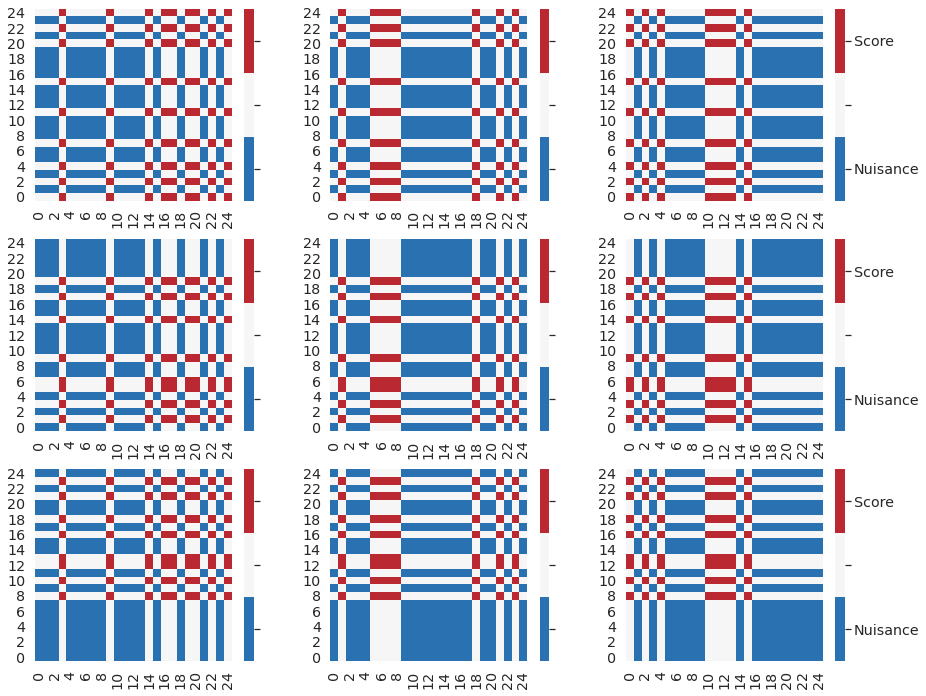

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



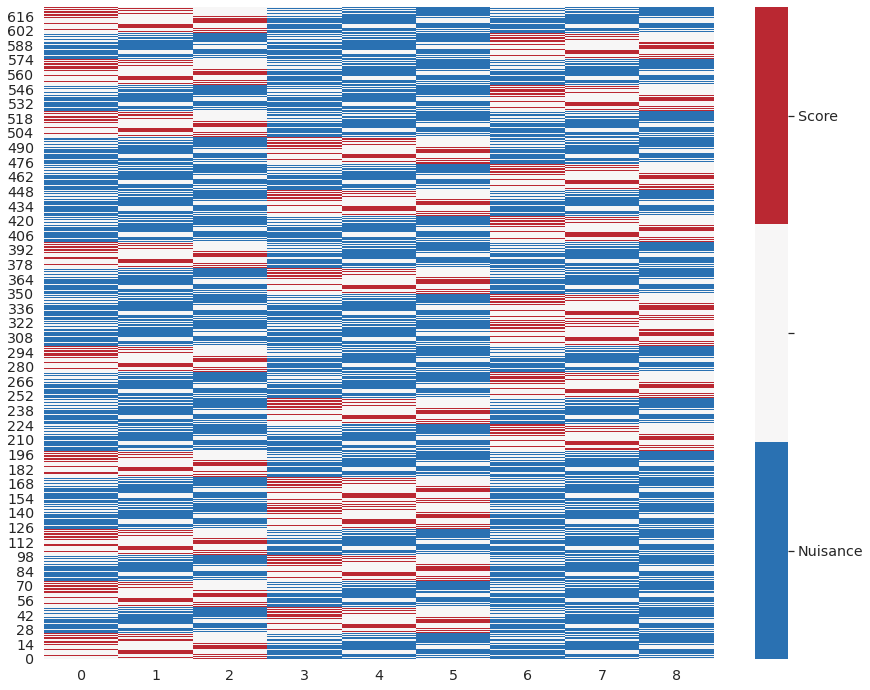

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])